In [1]:
from datetime import datetime 
from concurrent import futures 
import pandas as pd
import pandas_datareader.data as web
%matplotlib inline    

In [2]:
tickers = pd.read_csv('spy/tickers.csv', header=None)[1].tolist()
start = datetime(2014,4,28)
end = datetime(2019,4,25)



In [3]:
import backtrader as bt
import numpy as np

determine the long or short capitol $w_i$ allocated to the $i^{th}$ stock

$w_i = -$

In [39]:
num_posititons = 100

def min_n(array, n):
    return np.argpartition(array, n)[:n]

def max_n(array, n):
    return np.argpartition(array, -n)[-n:]

class CrossSectionalMR(bt.Strategy):
    def __init__(self):
        self.inds = {}
        for d in self.datas:
            self.inds[d] = {}
            self.inds[d]["pct"] = bt.indicators.PercentChange(d.close, period=5)
            self.inds[d]["std"] = bt.indicators.StandardDeviation(d.close, period=5)

    def prenext(self):
        self.next()
    
    def next(self):
        available = list(filter(lambda d: len(d) > 5, self.datas)) # only look at data that existed last week
        rets = np.zeros(len(available))
        stds = np.zeros(len(available))
            
        for i, d in enumerate(available):
            rets[i] = self.inds[d]['pct'][0]
            stds[i] = self.inds[d]['std'][0]

        market_ret = np.mean(rets)
        weights = -(rets - market_ret)
        
        max_weights_index = max_n(np.abs(weights), num_posititons)
        low_volality_index = min_n(stds, num_posititons)
        
        selected_weights_index = np.intersect1d(max_weights_index,
                                                low_volality_index)
        
        if not len(selected_weights_index):
            # no good trades today
            return
            
        selected_weights = weights[selected_weights_index]
        
        
        weights = weights / np.sum(np.abs(selected_weights))
                
        for i, d in enumerate(available):
            if i in selected_weights_index:
                self.order_target_percent(d, target=weights[i])
            else:
                self.order_target_percent(d, 0)

In [40]:
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)

for ticker in tickers:
    data = bt.feeds.GenericCSVData(
        fromdate=start,
        todate=end,
        dataname=f"spy/{ticker}.csv",
        dtformat=('%Y-%m-%d'),
        openinterest=-1,
        nullvalue=0.0,
        plot=False
    )
    cerebro.adddata(data)

cerebro.broker.setcash(10_000)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(CrossSectionalMR)
results = cerebro.run()

<IPython.core.display.Javascript object>


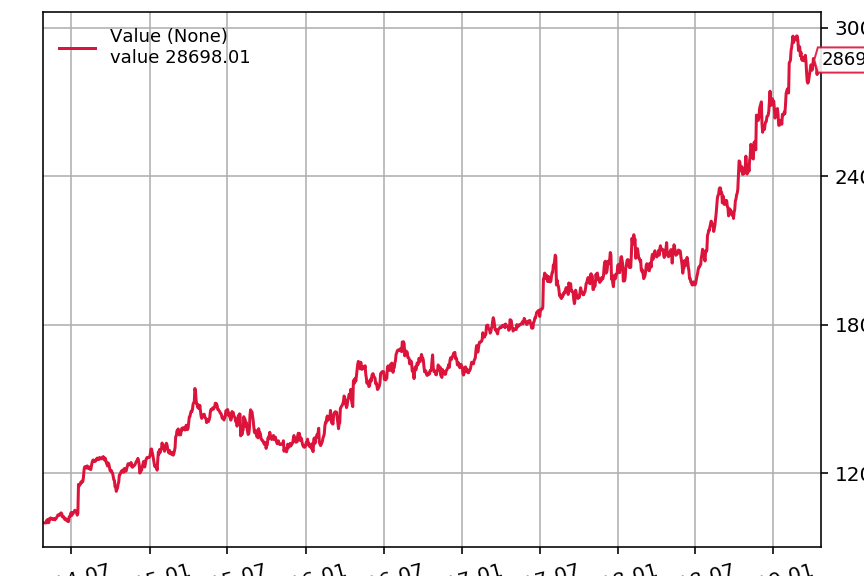

[[<Figure size 432x288 with 1 Axes>]]

In [41]:
cerebro.plot()

In [37]:
results[0].analyzers.sharperatio.get_analysis()

OrderedDict([('sharperatio', 1.309511894183078)])

In [38]:
results[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 0.9800636650240179),
             ('ravg', 0.0007796846977120269),
             ('rnorm', 0.2171116403088498),
             ('rnorm100', 21.71116403088498)])

In [9]:
results[0].analyzers.drawdown.get_analysis()

AutoOrderedDict([('len', 39),
                 ('drawdown', 3.287507285280529),
                 ('moneydown', 975.5194999999912),
                 ('max',
                  AutoOrderedDict([('len', 255),
                                   ('drawdown', 16.598831159750144),
                                   ('moneydown', 2561.076800000028)]))])

In [10]:
tickers

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AMG',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'APC',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ARNC',
 'ANET',
 'AJG',
 'AIZ',
 'ATO',
 'T',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BHGE',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BBT',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'HRB',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CPRI',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CBS',
 'CE',
 'CELG',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'XEC',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS

In [22]:
from key import ALPHA_VANTAGE
import requests

In [32]:
for ticker in tickers:
    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": ticker,
        "interval": "15min",
        "outputsize": "full",
        "apikey": ALPHA_VANTAGE,
        "datatype": "csv",
    }
    data = requests.get("https://www.alphavantage.co/query", params=params)
    with open(f"spy_5min/{ticker}.csv", "wb") as f:
        f.write(data.content)

In [33]:
!ls spy_5min/

A.csv	  BMY.csv    DRI.csv	HCA.csv   LNT.csv   PFE.csv   TJX.csv
AAL.csv   BR.csv     DTE.csv	HCP.csv   LOW.csv   PFG.csv   TMK.csv
AAP.csv   BRK.B.csv  DUK.csv	HD.csv	  LRCX.csv  PG.csv    TMO.csv
AAPL.csv  BSX.csv    DVA.csv	HES.csv   LUV.csv   PGR.csv   TPR.csv
ABBV.csv  BWA.csv    DVN.csv	HFC.csv   LW.csv    PH.csv    TRIP.csv
ABC.csv   BXP.csv    DWDP.csv	HIG.csv   LYB.csv   PHM.csv   TROW.csv
ABMD.csv  C.csv      DXC.csv	HII.csv   M.csv     PKG.csv   TRV.csv
ABT.csv   CAG.csv    EA.csv	HLT.csv   MA.csv    PKI.csv   TSCO.csv
ACN.csv   CAH.csv    EBAY.csv	HOG.csv   MAA.csv   PLD.csv   TSN.csv
ADBE.csv  CAT.csv    ECL.csv	HOLX.csv  MAC.csv   PM.csv    TSS.csv
ADI.csv   CB.csv     ED.csv	HON.csv   MAR.csv   PNC.csv   TTWO.csv
ADM.csv   CBOE.csv   EFX.csv	HP.csv	  MAS.csv   PNR.csv   TWTR.csv
ADP.csv   CBRE.csv   EIX.csv	HPE.csv   MAT.csv   PNW.csv   TXN.csv
ADS.csv   CBS.csv    EL.csv	HPQ.csv   MCD.csv   PPG.csv   TXT.csv
ADSK.csv  CCI.csv    EMN.csv	HRB.csv   MCHP.csv  PPL.csv   UA.